# Buchdichte in Berlin

## Daten von Das Örtliche

Die Adressen der Buchhandlungen werden von den Seiten von [Das Örtliche](www.dasoertliche.de) bezogen.

In [165]:
import requests
from lxml import etree
import re
from collections import Counter,defaultdict

In [53]:
FROM = 1

In [54]:
oertliche = f"https://www.dasoertliche.de/?seo=true&zvo_ok=0&buc=&plz=&quarter=&district=&ciid=&fn=&kw=Buchhandlungen&ci=Berlin&st=&radius=0&kgs=&buab=&zbuab=&form_name=search_nat_ext&recFrom={FROM}"

In [55]:
res = requests.get(oertliche)

In [56]:
parser = etree.HTMLParser()
tree   = etree.fromstring(res.text, parser)

In [62]:
total_hits = int(tree.find('.//span[@class="sttrefferanz"]').text)

In [265]:
def parseResponse(res) -> list:
    '''Liest HTTP-Response von Das Örtliche aus und gibt eine '''
    tree   = etree.fromstring(res.text, parser)
    results = []
    for div in tree.findall('.//div[@class = "hit "]'):
        name = div.find('h2/a').text.strip()
        link = div.find('h2/a').attrib.get('href').strip()
        tmp_address = div.find('.//address')
        address = []
        for x in tmp_address.iter():
            if x.text is not None:
                text = x.text.strip()
                if len(text) > 0:
                    address.append(text)
            if x.tail is not None:
                tail = x.tail.strip()
                if len(tail) > 0:
                    address.append(tail)
        for a in adress:
            PLZ = None
            try:
                PLZ = re.search(r'1\d{4}',a).group()
            except Exception as e:
                print(e)

        results.append({
            'name' : name,
            'link' : link,
            'address' : address,
            'PLZ' : PLZ
        })
    return results

In [64]:
buchhandlungen = []

In [65]:
for FROM in range(1,total_hits + 1, 25):
    oertliche = f"https://www.dasoertliche.de/?seo=true&zvo_ok=0&buc=&plz=&quarter=&district=&ciid=&fn=&kw=Buchhandlungen&ci=Berlin&st=&radius=0&kgs=&buab=&zbuab=&form_name=search_nat_ext&recFrom={FROM}"
    res = requests.get(oertliche)
    _ = parseResponse(res)
    buchhandlungen.extend(_)

In [169]:
bhCounter = Counter(b.get('PLZ') for b in buchhandlungen)

## Bevölkerungsstatistik

https://www.statistik-berlin-brandenburg.de/a-i-5-hj

In [99]:
import pandas as pd
from io import BytesIO

In [116]:
url = "https://download.statistik-berlin-brandenburg.de/31b0e1f55fbede61/0a9d61e4323b/SB_A01-05-00_2022h01_BE.xlsx"
res = requests.get(url)

In [159]:
df = pd.read_excel(BytesIO(res.content),
                   sheet_name = "T14",
                   skiprows = lambda x: x in [0,1,3,4],
                   converters = {
                       'Postleitzahl' : str,
                       'Ins-\ngesamt' : int
                   },
                   nrows = 237
                  )

In [167]:
bevoelkerung = dict(zip(df['Postleitzahl'],df['Ins-\ngesamt']))

In [209]:
bevoelkerung = defaultdict(int)

In [210]:
for plz,pop in zip(df['Postleitzahl'],df['Ins-\ngesamt']):
    bevoelkerung[plz] += pop

## Buchladendichte

In [266]:
dichte = dict()
for plz,pop in bevoelkerung.items():
    bh = bhCounter.get(plz,0)  
    try:
        dichte[plz] = bh/pop
    except Exception as e:
        print(e)

In [269]:
from matplotlib import pyplot as plt

In [273]:
xs = []
ys = []
for n,(plz, bhdichte) in enumerate(sorted(dichte.items(), key = lambda x:x[1], reverse = True)):
    if n < 11:
    #if len(dichte) * 0.2 < n < len(dichte) * 0.8:
        xs.append(plz)
        ys.append(bhdichte * 10000)

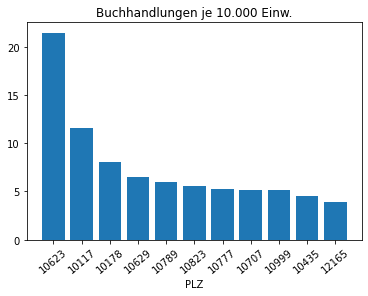

In [274]:
plt.bar(xs,ys)
plt.title("Buchhandlungen je 10.000 Einw.")
plt.xlabel("PLZ")
plt.xticks(rotation=40, ha = "center")
plt.show()

### CSV-Export

In [278]:
with open("buchladendichteBerlin.csv","w") as OUT:
    for plz,bhdichte in dichte.items():
        print(f"{plz},{bh}", file = OUT)